In [1]:
%run ../setup_notebook.ipynb

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1109: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1110: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dvar_e_dw = np.dot(s2.T, V)
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1111: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  tmp3 = np.dot(s3.T, V)
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:946: NumbaPerformanceWar

/home/thijs/repos/dnp-code/rbm_pipeline_functions.py


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /home/thijs/Desktop/zf_rbm_essentials/20180912_Run01_spontaneous_rbm2.h5
len test inds 1665


In [2]:
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar as mpl_colorbar
from sklearn.mixture import GaussianMixture

import plotting_functions as pf
import analysis_functions as af
import swap_sign_RBM as ssrbm
pf.set_fontsize(font_size=12)
%load_ext autoreload
%autoreload 2
# train_data['wb'].shape

In [3]:
weights = {}

## PCA & ICA

In [4]:
### PCA & ICA
all_nr_methods = []

# mapping = {}
# inverse_mapping = {}
n_comps = {'wb': 200}
bool_pca, bool_ica, bool_fa = True, False, False

def add_new_methods(name, region):
    assert weights[name].shape[0] < weights[name].shape[1]
    print(weights[name].shape, name)
#     mapping[name] = lambda high_data, w=weights[name]: np.dot(w, high_data)
#     inverse_mapping[name] = lambda low_data, w=weights[name].transpose(): np.dot(w, low_data)
    all_nr_methods.append(name)
#     low_dyn_test[name] = mapping[name](test_data[region])
#     low_dyn_train[name] = mapping[name](train_data[region])
#     low_dyn_full[name] = mapping[name](full_data[region])
    
for ir, r in enumerate(list(n_comps.keys())):
    if bool_pca:
        pca_model = sklearn.decomposition.PCA(n_components=n_comps[r])
        pca_model.fit(np.transpose(train_data[r]))
        print(pca_model)
        model_name = f'pca' 
        weights[model_name] = pca_model.components_
        add_new_methods(name=model_name, region=r)

    if bool_ica:
        ica_model = sklearn.decomposition.FastICA(n_components=n_comps[r])
        ica_model.fit(np.transpose(train_data[r]))
        print(ica_model)
        model_name = f'ica' 
        weights[model_name] = ica_model.components_
        add_new_methods(name=model_name, region=r)
    
    if bool_fa:
        fa_model = sklearn.decomposition.FactorAnalysis(n_components=n_comps[r])
        fa_model.fit(np.transpose(train_data[r]))
        print(fa_model)
        model_name = f'fa'
        weights[model_name] = fa_model.components_
        add_new_methods(name=model_name, region=r)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
(200, 52518) pca


In [4]:
# rbm_path = '/media/thijs/hooghoudt/new_sweep_april20/RBM_sweep_reruns/RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M200_l1-2e-02_duration208093s_timestamp2020-05-16-0844.data'
rbm_path = '/home/thijs/Desktop/zf_rbm_essentials/RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M200_l1-2e-02_duration208093s_timestamp2020-05-16-0844.data'
hu_assert = [1,  11,  12,  19,  30,  36,  37,  38,  41,  43,  52,  55,  67, 68,  70,  72,  88,  94,  95,  99, 100, 107, 111, 117, 118, 120, 124, 128, 133, 136, 138, 140, 151, 152, 167, 170, 171, 172, 175, 177, 181, 186, 188, 191, 198]  # HUs that sholud be swapped
tmp_RBM = pickle.load(open(rbm_path, 'rb'))
RBM = ssrbm.swap_sign_RBM(RBM=tmp_RBM, verbose=2, assert_hu_inds=hu_assert)
weights['rbm'] = RBM.weights.copy()

hu_act_test = np.transpose(RBM.mean_hiddens(test_data['wb'].T))
ol, tmp = af.opt_leaf(hu_act_test)
hu_act_test_remap = hu_act_test[ol, :]

45/200 HU weights are flipped
Flipped HUs are: (array([  1,  11,  12,  19,  30,  36,  37,  38,  41,  43,  52,  55,  67,
        68,  70,  72,  88,  94,  95,  99, 100, 107, 111, 117, 118, 120,
       124, 128, 133, 136, 138, 140, 151, 152, 167, 170, 171, 172, 175,
       177, 181, 186, 188, 191, 198]),)


In [6]:
print(RBM.vlayer.n_c)
print(RBM.weights.ndim)
print(RBM.weights.shape[0])
print(RBM.vlayer.N)
print(test_data['wb'].T.shape)
print(RBM.weights.T.shape)
print(RBM.hlayer)

1
2
200
52518
(1665, 52518)
(52518, 200)


In [6]:
## Compute sparsity of zbrain regions
plot_methods = ['pca', 'rbm']
weighted_labels = {}
include_empty_regions = False

plot_labels = rec.labels[inds_wb, :].A
if include_empty_regions:
    ind_regions = set(np.arange(plot_labels.shape[1]))
else: 
    ind_regions = set(np.where(plot_labels.sum(0))[0])  # where non zero
ind_regions = np.array(list(ind_regions.difference(set([0, 93, 113, 218, 219, 220, 221, 222, 223, 224, 259, 274]))))  # take out main regions
plot_labels = np.squeeze(plot_labels[:, ind_regions])  # non zero, non main region labels


sparsity_vector = {}
for dr in plot_methods:
    n_hu = weights[dr].shape[0]
    n_regions = plot_labels.shape[1]
    sparsity_vector[dr] = np.zeros(n_hu)  # number of HUs/PCs
    weighted_labels[dr] = np.zeros((n_hu, n_regions))
    for mu in range(n_hu):
        weighted_labels[dr][mu, :] = af.freq_distr_weighted_regions(w_vector=weights[dr][mu, :], 
                                                             m_labels=plot_labels)  # region labels weighted by this HU's weights
        sparsity_vector[dr][mu] = af.p_metric_per_hu(weighted_labels[dr][mu, :]) * n_regions  # PR
    weighted_labels[dr] *= 100
## Old PR metric
# part_ratio_activity = {x: np.zeros(test_data['wb'].shape[1]) for x in ['rbm', 'pca']}
# for t in range(test_data['wb'].shape[1]):
#     pc_act = np.dot(weights['pca'], test_data['wb'][:, t])
#     part_ratio_activity['pca'][t] = af.p_metric_per_hu(pc_act)
#     hu_act = RBM.mean_hiddens(test_data['wb'][:, t].T)
#     part_ratio_activity['rbm'][t] = af.p_metric_per_hu(hu_act)

In [7]:
region_divisions_full_limits = {'diencephalon': [0, 75],
                               'ganglia': [76, 92],
                               'mesencephalon': [93, 112],
                               'rhombencephalon': [113, 258],
                               'spinal cord': [259, 273],
                               'telencephalon': [274, 293]}  # inclusive limits on both ends

region_divisions_abbrev = {'diencephalon': 'Di',
                           'ganglia': 'Ga',
                           'mesencephalon': 'Me',
                           'rhombencephalon': 'Rh',
                           'spinal cord': 'SC',
                           'telencephalon': 'Te'}  # inclusive limits on both ends

region_divisions_nz_limits = {}
for k, v in region_divisions_full_limits.items():
    region_divisions_nz_limits[k] = np.argmax(ind_regions[ind_regions <= v[1]])
region_end_list = [0] + [v for v in region_divisions_nz_limits.values()]
region_middle_list = [int((region_end_list[k] + region_end_list[k + 1]) / 2) for k in range(len(region_end_list) - 1)]
# print(region_end_list, region_middle_list)
print(region_middle_list)
region_middle_list[0] = 8
region_middle_list[2] = 40
region_middle_list[5] = 202

[11, 25, 36, 112, 185, 198]


In [9]:
ind_regions.shape

(206,)

In [10]:
for dr in sparsity_vectorsity_vector.keys():
    print(dr)
    print(f'Mean: {np.mean(sparsity_vector[dr])}, std: {np.std(sparsity_vector[dr])}')
    print('---')

pca
Mean: 150.59495426671597, std: 26.630847897905063
---
rbm
Mean: 5.142912099985442, std: 9.946778293204478
---


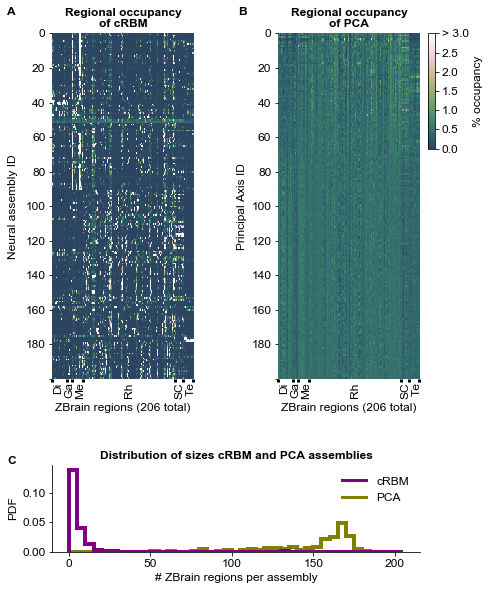

In [12]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=[6, 8])
gs_matrix = fig.add_gridspec(ncols=2, nrows=1, bottom=0.35, top=0.95, 
                             hspace=0.6, wspace=0.6, left=0.05, right=0.9)
gs_stats = fig.add_gridspec(ncols=1, nrows=1, bottom=0.05, top=0.2, 
                             hspace=0.6, wspace=0.6, left=0.05, right=0.9)

ax_rbm_mat = fig.add_subplot(gs_matrix[0])
ax_pca_mat = fig.add_subplot(gs_matrix[1])
ax_spars = fig.add_subplot(gs_stats[0])

## RBM
# cmap_matrix = sns.cubehelix_palette(start=.5, rot=-1, dark=0, light=1, 
#                                     reverse=False, as_cmap=True, n_colors=10)
cmap_matrix = sns.cubehelix_palette(start=.5, rot=-1, dark=0.25, light=1, 
                                    reverse=True, as_cmap=True, n_colors=10)
hm = sns.heatmap(weighted_labels['rbm'][ol, :],
            cmap=cmap_matrix, linewidths=0,
            ax=ax_rbm_mat, vmax=3, rasterized=True,
            cbar=False)
ax_rbm_mat.set_ylabel('Neural assembly ID')
ax_rbm_mat.set_title('Regional occupancy\nof cRBM', fontdict={'weight': 'bold'})
ax_rbm_mat.grid(False)

## PCA
sns.heatmap(weighted_labels['pca'], 
            cmap=cmap_matrix, rasterized=True,
            ax=ax_pca_mat, vmax=3, linewidths=0,
            cbar=False)
ax_pca_mat.set_ylabel('Principal Axis ID')
ax_pca_mat.set_title('Regional occupancy\nof PCA', fontdict={'weight': 'bold'})
ax_pca_mat.grid(False)

# labelling:
for ax in [ax_rbm_mat, ax_pca_mat]:
    ax.set_yticks(np.arange(11) * 20)
    ax.set_yticklabels([str(x * 20) for x in range(10)] + [''])
    
    ax.set_xticks(region_end_list, minor=False)  # minor: indicate ends of regions
    ax.set_xticks(region_middle_list, minor=True)  # major: used for region names 
    ax.set_xticklabels([region_divisions_abbrev[x] for x in region_divisions_nz_limits.keys()], fontdict={'ha': 'center'},
                       minor=True, rotation=90)
    ax.set_xticklabels(['' for x in region_end_list], minor=False)
    ax.tick_params(which='major', width=3, length=3, axis='x', pad=-70)
    ax.tick_params(which='minor', width=0, length=0, axis='x')
    ax.set_xlabel(f'ZBrain regions ({len(ind_regions)} total)')
    
## color bar 
ax_cbar = fig.add_axes([0.92, 0.75, 0.015, 0.2])  # left, bottom ,width, height
occ_cb = fig.colorbar(ax_rbm_mat.get_children()[0], cax=ax_cbar)
occ_cb.solids.set_rasterized(True)
ax_cbar.set_ylabel('% occupancy')
ax_cbar.yaxis.set_ticks(np.arange(7) * 0.5)
ax_cbar.set_yticklabels([str(x) for x in (np.arange(6) * 0.5)] + ['> 3.0'])

## Sparsity of regions
plot_bins = np.arange(0, len(ind_regions), 5)
for dr in plot_methods:
    #     plt.hist(sparsity_vector[dr], bins=plot_bins, label=dr)
    sns.distplot(sparsity_vector[dr], hist=True, kde=False, bins=plot_bins,
                 label=dr_names[dr], color=dr_colors[dr], ax=ax_spars,
                 kde_kws={'linewidth': 4}, hist_kws={'histtype':'step', 'linewidth':4, 'alpha':1, 'density':True})  # prev alpha 0.7 lw 2
ax_spars.set_xlabel('# ZBrain regions per assembly'); 
ax_spars.set_ylabel('PDF'); 
ax_spars.set_title('Distribution of sizes cRBM and PCA assemblies', fontdict={'weight': 'bold'});
ax_spars.spines['top'].set_visible(False)
ax_spars.spines['right'].set_visible(False)
handle_dict = {dr: matplotlib.lines.Line2D([], [], c=dr_colors[dr]) for dr in ['rbm', 'pca']}
ax_spars.legend(handles=[handle_dict['rbm'], handle_dict['pca']],
                labels=[dr_names['rbm'], dr_names['pca']],
                frameon=False, loc='upper right');
fig.align_ylabels(axs=[ax_rbm_mat, ax_spars])

ax_spars.text(s='A', x=-38, y=0.913, fontdict={'weight': 'bold'})
ax_spars.text(s='B', x=104, y=0.913, fontdict={'weight': 'bold'})
ax_spars.text(s='C', x=-38, y=0.15, fontdict={'weight': 'bold'})

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_region_sparsity.pdf', 
                dpi=300, bbox_inches='tight')

In [15]:
## Uniformity of connectivity:

## Original metric:
# w_th_arr, curve_NVUgeqKw, sh_curve_NVUgeqKw = {}, {}, {}
# print(f'Methods: {plot_methods}')
# for dr in plot_methods:
#     print(f'calculating {dr}')
#     w_th_arr[dr], curve_NVUgeqKw[dr], sh_curve_NVUgeqKw[dr] = af.count_connections(weight_matrix=weights[dr],
#                                                                                 n_w_th=250, perc_top=100)

## New metric:
# all_w_arrs, all_sh_w_arrs, all_cdfs, all_sh_cdfs = {}, {}, {}, {}
degree_distr, sh_degree_distr = {}, {}
print(f'Methods: {plot_methods}')
for dr in plot_methods:
#     print(f'calculating {dr}')
#     all_w_arrs[dr], all_sh_w_arrs[dr], all_cdfs[dr], all_sh_cdfs[dr] = af.count_connections_3(weight_matrix=weights[dr],
#                                                                                 n_w_th=250)

    degree_distr[dr], sh_degree_distr[dr] = af.count_connections_3(weight_matrix=weights[dr])

Methods: ['pca', 'rbm']


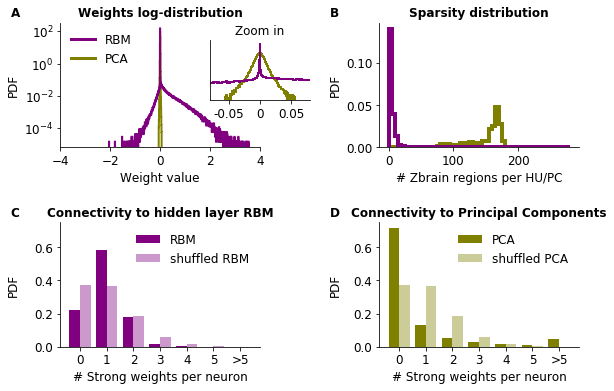

In [27]:
plt.rcParams['figure.figsize'] = (8, 5)
save_fig = False

fig = plt.figure(constrained_layout=False)
gs_stats = fig.add_gridspec(ncols=2, nrows=2, bottom=0.05, top=0.95, 
                         hspace=0.6, wspace=0.6, left=0.05, right=0.95) 


## Sparsity of regions
ax_spars = fig.add_subplot(gs_stats[1])
plot_bins = np.arange(0, len(ind_regions), 5)
for dr in plot_methods:
    #     plt.hist(sparsity_vector[dr], bins=plot_bins, label=dr)
    sns.distplot(sparsity_vector[dr], hist=True, kde=False, bins=plot_bins,
                 label=dr_legend[dr], color=dr_colors[dr], ax=ax_spars,
                 kde_kws={'linewidth': 4}, hist_kws={'histtype':'step', 'linewidth':4, 'alpha':1, 'density':True})  # prev alpha 0.7 lw 2
ax_spars.set_xlabel('# Zbrain regions per HU/PC'); 
ax_spars.set_ylabel('PDF'); 
ax_spars.set_title('Sparsity distribution', fontdict={'weight': 'bold'});
ax_spars.spines['top'].set_visible(False)
ax_spars.spines['right'].set_visible(False)

## Weights distribution
ax_mainw = fig.add_subplot(gs_stats[0])
plot_bins = np.linspace(np.min([weights[x].min() for x in weights.keys()]), 
                        np.max([weights[x].max() for x in weights.keys()]), 1000)
for dr in plot_methods:
    ax_mainw.hist(np.ravel(weights[dr]), bins=plot_bins, histtype='step', label=dr_legend[dr],
             density=True, linewidth=2, color=dr_colors[dr])
ax_mainw.set_yscale('log'); ax_mainw.set_xlabel('Weight value'); 
ax_mainw.set_ylabel('PDF'); 
ax_mainw.set_title('Weights log-distribution', fontdict={'weight': 'bold'})
ax_mainw.set_xlim([-4, 4])
ax_mainw.spines['top'].set_visible(False)
ax_mainw.spines['right'].set_visible(False)
handle_dict = {dr: matplotlib.lines.Line2D([], [], c=dr_colors[dr]) for dr in ['rbm', 'pca']}
ax_mainw.legend(handles=[handle_dict['rbm'], handle_dict['pca']],
                labels=[dr_legend['rbm'], dr_legend['pca']],
                frameon=False, loc='upper left');

## Weights distribution Zoom inset
ax_zoomw = ax_mainw.inset_axes([0.75, 0.38, 0.5, 0.48])
for dr in plot_methods:
    ax_zoomw.hist(np.ravel(weights[dr]), bins=np.linspace(-0.11, 0.11, 500), 
                  histtype='step', label=dr_legend[dr],
                  density=True, linewidth=2, color=dr_colors[dr])
ax_zoomw.get_yaxis().set_visible(False);
ax_zoomw.get_xaxis().set_ticklabels(['', '-0.05', '0', '0.05'])
ax_zoomw.set_yscale('log'); ax_zoomw.set_xlim([-0.08, 0.08]); 
ax_zoomw.set_ylim([1e-4, 5e3])
ax_zoomw.set_title('Zoom in')
ax_zoomw.spines['top'].set_visible(False)
ax_zoomw.spines['right'].set_visible(False)

## Uniformity plots
ax_unif = {}
for i_dr, dr in enumerate(['rbm', 'pca']):
    ax_unif[dr] = fig.add_subplot(gs_stats[2 + i_dr])
    pf.plot_degree_distr(degree_dict=degree_distr, degree_dict_sh=sh_degree_distr,
                         dr=dr, ax=ax_unif[dr], cutoff=6, normalise=True)
    ax_unif[dr].set_ylim([0, 0.75])
ax_unif['pca'].set_title('Connectivity to Principal Components', 
                         fontdict={'weight': 'bold'})

##  Alignment
fig.align_ylabels(axs=[ax_mainw, ax_unif['rbm']])
fig.align_ylabels(axs=[ax_spars, ax_unif['pca']])
fig.align_xlabels(axs=[ax_spars, ax_mainw])
fig.align_xlabels(axs=[ax_unif['rbm'], ax_unif['pca']])

ax_mainw.annotate(s='A', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')
ax_spars.annotate(s='B', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')
ax_unif['rbm'].annotate(s='C', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')
ax_unif['pca'].annotate(s='D', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_hu_structure_stats.pdf', bbox_inches='tight')

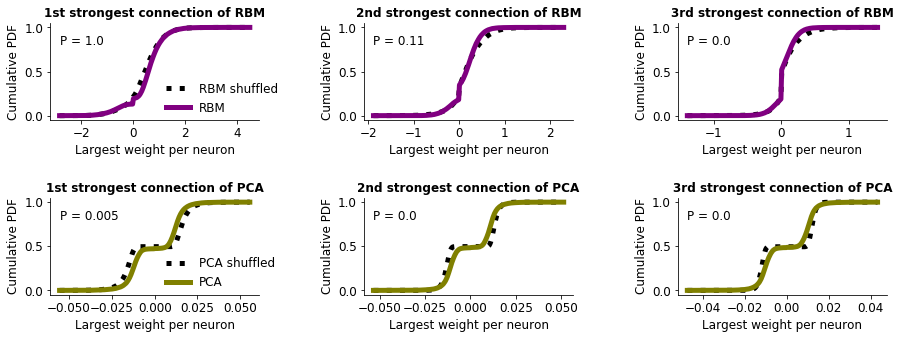

In [239]:
# ## Supplemental figure of uniform
# for dr in plot_methods:
#     for kk in range(all_cdfs[dr].shape[0]):
#         distr = all_cdfs[dr][kk, :]
#         sh_distr = all_sh_cdfs[dr][kk, :]
#         print(f'{dr}: K = {kk} P value = {np.round(scipy.stats.ks_2samp(distr, sh_distr)[1], 3)}')


# plt.rcParams['figure.figsize'] = (15, 5)
# plt.subplots_adjust(hspace=0.8, wspace=0.5)
# ax_unif_dict = {}
# dict_str_number = {0: '1st', 1: '2nd', 2: '3rd'}
# for i_dr, dr in enumerate(['rbm', 'pca']):
#     for i_k, k_value in enumerate([0, 1, 2]):
#         i_plot = 1 + i_k + (3 * i_dr)
#         ax_unif_dict[i_plot] = plt.subplot(2, 3, i_plot)
#         _ = pf.plot_uniform_distr(w_mat=all_w_arrs, sh_w_mat=all_sh_w_arrs,
#                                   cdf_mat=all_cdfs, sh_cdf_mat=all_sh_cdfs,
#                                   k_value=k_value, dr=dr, print_pval=True,
#                                   plot_legend=(i_k == 0), ax=ax_unif_dict[i_plot])

# DYNAMICS

In [5]:
hu_act_test = np.transpose(RBM.mean_hiddens(test_data['wb'].T))
ol, (link_mat, _) = af.opt_leaf(hu_act_test)
reverse_ol = np.zeros_like(ol)
for i_new, i_old in enumerate(ol):
    reverse_ol[i_old] = i_new
hu_act_test_remap = hu_act_test[ol, :]

In [62]:
freq = 1 / np.mean(np.diff(rec.time))
print(f'frequency = {freq}')
split_tp = int(np.where(np.diff(test_inds) > 1)[0]) + 1
print(len(test_inds), split_tp)
# median_hu_period = af.compute_median_state_occupancy(activity=hu_act_test_remap, freq=freq)
median_vu_period = af.compute_median_state_occupancy(activity=test_data['wb'], 
                                                     bimodality=0.5, freq=freq,
                                                     tp_split_arr=np.array([split_tp]))  # compute period of (neuron) binary data

(median_silence_duration_filtered, median_burst_duration_filtered, median_period_duration_filtered, 
 count_bursts_filtered) = af.compute_median_discretised_state_occupancy(activity_mat=hu_act_test_remap, 
                                                               frequency=freq, margin=0.4,
                                                               tp_split_arr=np.array([split_tp]))  # compute period of HUs with margin < 0.5

(median_silence_duration, median_burst_duration, median_period_duration, 
 count_bursts) = af.compute_median_discretised_state_occupancy(activity_mat=hu_act_test_remap, 
                                                               frequency=freq, margin=0.5,
                                                               tp_split_arr=np.array([split_tp]))  # compute period of HUs with margin == 0.5

## demean HU activity by using average between its 2 peaks (foudn by GMM)
hu_activity_effectively_demeaned = hu_act_test_remap.copy()
for mu in range(hu_act_test_remap.shape[0]):
    gmm = GaussianMixture(n_components=2).fit(hu_act_test_remap[mu, :, np.newaxis])
    two_peaks = gmm.means_[:2]
    effective_mean = two_peaks.mean()
    hu_activity_effectively_demeaned[mu, :] -= effective_mean

frequency = 3.3003290254073083
1665 555
Number of units: 200
Splitting at time points [555]
Number of units: 200
Splitting at time points [555]


In [50]:
# len(median_vu_period[:, 2])
scipy.stats.mannwhitneyu(median_period_duration, median_vu_period[:, 2], alternative='greater')
# scipy.stats.ks_2samp(median_vu_period[:, 2], median_period_duration, alternative='less')

MannwhitneyuResult(statistic=7065871.0, pvalue=1.3321276222274785e-17)

cut off decreased to max degree 11


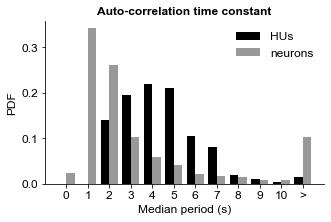

In [74]:
plt.rcParams['figure.figsize'] = (5, 3)
ax_hist_inter_mainstate = plt.subplot(111)
pf.plot_degree_distr(degree_dict_sh={'ea': median_vu_period[:, 0].round().astype('int')},
                     degree_dict={'ea': median_period_duration.round().astype('int')},
                     ax=ax_hist_inter_mainstate, plot_shuffled=True,
                     cutoff=15, normalise=True, dr='ea', colour='k',
                     label='HUs', label_sh='neurons', v_spacing_greater=True)

ax_hist_inter_mainstate.set_xlabel('Median period (s)')
ax_hist_inter_mainstate.set_ylabel('PDF')
ax_hist_inter_mainstate.set_title('Auto-correlation time constant', weight='bold')
ax_hist_inter_mainstate.spines['right'].set_visible(False)
ax_hist_inter_mainstate.spines['top'].set_visible(False)
ax_hist_inter_mainstate.legend(loc='upper right', frameon=False);


(array([90., 18., 27., 20., 20., 19.,  2.,  1.,  1.,  2.]),
 array([ 0.        ,  1.27260039,  2.54520078,  3.81780117,  5.09040155,
         6.36300194,  7.63560233,  8.90820272, 10.18080311, 11.4534035 ,
        12.72600389]),
 <a list of 10 Patch objects>)

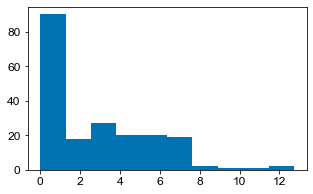

In [36]:
plt.hist(median_period_duration)

In [9]:
# ## export dynamics
# hfile_name = '/home/thijs/Google Drive/M_Internship/Data/spontaneous/hu_activity_20180912-Run01_timestamp2020-05-16-0844.h5'
# hfile = h5py.File(hfile_name, 'w')
# hfile.create_dataset('hu_activity_test', data=hu_act_test_remap)
# hfile.create_dataset('hu_activity_test_demeaned', data=hu_activity_effectively_demeaned)
# hfile.create_dataset('rbm_path', data=rbm_path)
# hfile.create_dataset('hu_ol_indices', data=ol)
# hfile.close()

In [13]:
# hfile = h5py.File(hfile_name, 'r')
# # hfile['hu_activity_test']
# hfile.close()

# Compostional phase 

3.3003290254073083

In [15]:
# tmp

In [88]:
if False:  # computationally expensive! create all PR of connectiivty rbms 
    ## All connectivity estimate RBMs:
    pr_dict_demean = af.get_all_prs_rbms(demean_or_depeak='demean', bool_set_zero=True)
    pr_dict_depeak = af.get_all_prs_rbms(demean_or_depeak='depeak')

0/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (7500, 26083) is not recognized, so it cannot be loaded.
drifts with shape (7500, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (7500, 26083) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 26083) is not recognized, so it cannot be loaded.
segmentation with shape (20, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (7500, 26083) is not recognized, so it cannot be loaded.
trace with shape (7500, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20190102_Run01_spontaneous5_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


1/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5000, 44456) is not recognized, so it cannot be loaded.
drifts with shape (5000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5000, 44456) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 44456) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5000, 44456) is not recognized, so it cannot be loaded.
trace with shape (5000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180913_Run01_rbm3.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


2/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5500, 45052) is not recognized, so it cannot be loaded.
drifts with shape (5500, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5500, 45052) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 45052) is not recognized, so it cannot be loaded.
segmentation with shape (20, 620, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 620, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (5500, 45052) is not recognized, so it cannot be loaded.
trace with shape (5500, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180706_Run04_spontaneous_rbm0.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))
/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: invalid value encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


3/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5975, 46174) is not recognized, so it cannot be loaded.
drifts with shape (5975, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5975, 46174) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 46174) is not recognized, so it cannot be loaded.
segmentation with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5975, 46174) is not recognized, so it cannot be loaded.
trace with shape (5975, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20181206_Run03_spontaneous1_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


4/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (6000, 67878) is not recognized, so it cannot be loaded.
drifts with shape (6000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (6000, 67878) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 67878) is not recognized, so it cannot be loaded.
segmentation with shape (30, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (6000, 67878) is not recognized, so it cannot be loaded.
trace with shape (6000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


5/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (6000, 67878) is not recognized, so it cannot be loaded.
drifts with shape (6000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (6000, 67878) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 67878) is not recognized, so it cannot be loaded.
segmentation with shape (30, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (6000, 67878) is not recognized, so it cannot be loaded.
trace with shape (6000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


6/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (7500, 26616) is not recognized, so it cannot be loaded.
drifts with shape (7500, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (7500, 26616) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 26616) is not recognized, so it cannot be loaded.
segmentation with shape (20, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (7500, 26616) is not recognized, so it cannot be loaded.
trace with shape (7500, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20190109_Run04_spontaneous7_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


7/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5000, 44456) is not recognized, so it cannot be loaded.
drifts with shape (5000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5000, 44456) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 44456) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5000, 44456) is not recognized, so it cannot be loaded.
trace with shape (5000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180913_Run01_rbm3.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


8/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (3663, 23743) is not recognized, so it cannot be loaded.
drifts with shape (3663, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (3663, 23743) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 23743) is not recognized, so it cannot be loaded.
segmentation with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (3663, 23743) is not recognized, so it cannot be loaded.
trace with shape (3663, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20181206_Run05_spontaneous2_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


9/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (7500, 26083) is not recognized, so it cannot be loaded.
drifts with shape (7500, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (7500, 26083) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 26083) is not recognized, so it cannot be loaded.
segmentation with shape (20, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (7500, 26083) is not recognized, so it cannot be loaded.
trace with shape (7500, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20190102_Run01_spontaneous5_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


10/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


11/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5000, 44456) is not recognized, so it cannot be loaded.
drifts with shape (5000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5000, 44456) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 44456) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5000, 44456) is not recognized, so it cannot be loaded.
trace with shape (5000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180913_Run01_rbm3.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


12/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (6000, 67878) is not recognized, so it cannot be loaded.
drifts with shape (6000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (6000, 67878) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 67878) is not recognized, so it cannot be loaded.
segmentation with shape (30, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (6000, 67878) is not recognized, so it cannot be loaded.
trace with shape (6000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


13/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


14/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


15/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (6000, 67878) is not recognized, so it cannot be loaded.
drifts with shape (6000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (6000, 67878) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 67878) is not recognized, so it cannot be loaded.
segmentation with shape (30, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (6000, 67878) is not recognized, so it cannot be loaded.
trace with shape (6000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


16/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


17/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5975, 46174) is not recognized, so it cannot be loaded.
drifts with shape (5975, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5975, 46174) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 46174) is not recognized, so it cannot be loaded.
segmentation with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5975, 46174) is not recognized, so it cannot be loaded.
trace with shape (5975, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20181206_Run03_spontaneous1_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


18/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5975, 46174) is not recognized, so it cannot be loaded.
drifts with shape (5975, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5975, 46174) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 46174) is not recognized, so it cannot be loaded.
segmentation with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5975, 46174) is not recognized, so it cannot be loaded.
trace with shape (5975, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20181206_Run03_spontaneous1_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


19/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (7500, 26083) is not recognized, so it cannot be loaded.
drifts with shape (7500, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (7500, 26083) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 26083) is not recognized, so it cannot be loaded.
segmentation with shape (20, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (7500, 26083) is not recognized, so it cannot be loaded.
trace with shape (7500, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20190102_Run01_spontaneous5_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


20/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (6000, 67878) is not recognized, so it cannot be loaded.
drifts with shape (6000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (6000, 67878) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 67878) is not recognized, so it cannot be loaded.
segmentation with shape (30, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (6000, 67878) is not recognized, so it cannot be loaded.
trace with shape (6000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


21/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (3663, 23743) is not recognized, so it cannot be loaded.
drifts with shape (3663, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (3663, 23743) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 23743) is not recognized, so it cannot be loaded.
segmentation with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (3663, 23743) is not recognized, so it cannot be loaded.
trace with shape (3663, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20181206_Run05_spontaneous2_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


22/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


0/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (7500, 26083) is not recognized, so it cannot be loaded.
drifts with shape (7500, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (7500, 26083) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 26083) is not recognized, so it cannot be loaded.
segmentation with shape (20, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (7500, 26083) is not recognized, so it cannot be loaded.
trace with shape (7500, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20190102_Run01_spontaneous5_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


1/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5000, 44456) is not recognized, so it cannot be loaded.
drifts with shape (5000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5000, 44456) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 44456) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5000, 44456) is not recognized, so it cannot be loaded.
trace with shape (5000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180913_Run01_rbm3.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


2/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5500, 45052) is not recognized, so it cannot be loaded.
drifts with shape (5500, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5500, 45052) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 45052) is not recognized, so it cannot be loaded.
segmentation with shape (20, 620, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 620, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (5500, 45052) is not recognized, so it cannot be loaded.
trace with shape (5500, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180706_Run04_spontaneous_rbm0.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))
/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: invalid value encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


3/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5975, 46174) is not recognized, so it cannot be loaded.
drifts with shape (5975, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5975, 46174) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 46174) is not recognized, so it cannot be loaded.
segmentation with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5975, 46174) is not recognized, so it cannot be loaded.
trace with shape (5975, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20181206_Run03_spontaneous1_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


4/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (6000, 67878) is not recognized, so it cannot be loaded.
drifts with shape (6000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (6000, 67878) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 67878) is not recognized, so it cannot be loaded.
segmentation with shape (30, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (6000, 67878) is not recognized, so it cannot be loaded.
trace with shape (6000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


5/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (6000, 67878) is not recognized, so it cannot be loaded.
drifts with shape (6000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (6000, 67878) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 67878) is not recognized, so it cannot be loaded.
segmentation with shape (30, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (6000, 67878) is not recognized, so it cannot be loaded.
trace with shape (6000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


6/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (7500, 26616) is not recognized, so it cannot be loaded.
drifts with shape (7500, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (7500, 26616) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 26616) is not recognized, so it cannot be loaded.
segmentation with shape (20, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (7500, 26616) is not recognized, so it cannot be loaded.
trace with shape (7500, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20190109_Run04_spontaneous7_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


7/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5000, 44456) is not recognized, so it cannot be loaded.
drifts with shape (5000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5000, 44456) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 44456) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5000, 44456) is not recognized, so it cannot be loaded.
trace with shape (5000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180913_Run01_rbm3.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


8/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (3663, 23743) is not recognized, so it cannot be loaded.
drifts with shape (3663, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (3663, 23743) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 23743) is not recognized, so it cannot be loaded.
segmentation with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (3663, 23743) is not recognized, so it cannot be loaded.
trace with shape (3663, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20181206_Run05_spontaneous2_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


9/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (7500, 26083) is not recognized, so it cannot be loaded.
drifts with shape (7500, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (7500, 26083) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 26083) is not recognized, so it cannot be loaded.
segmentation with shape (20, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (7500, 26083) is not recognized, so it cannot be loaded.
trace with shape (7500, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20190102_Run01_spontaneous5_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


10/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


11/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5000, 44456) is not recognized, so it cannot be loaded.
drifts with shape (5000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5000, 44456) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 44456) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5000, 44456) is not recognized, so it cannot be loaded.
trace with shape (5000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180913_Run01_rbm3.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


12/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (6000, 67878) is not recognized, so it cannot be loaded.
drifts with shape (6000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (6000, 67878) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 67878) is not recognized, so it cannot be loaded.
segmentation with shape (30, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (6000, 67878) is not recognized, so it cannot be loaded.
trace with shape (6000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


13/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


14/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


15/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (6000, 67878) is not recognized, so it cannot be loaded.
drifts with shape (6000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (6000, 67878) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 67878) is not recognized, so it cannot be loaded.
segmentation with shape (30, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (6000, 67878) is not recognized, so it cannot be loaded.
trace with shape (6000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


16/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


17/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5975, 46174) is not recognized, so it cannot be loaded.
drifts with shape (5975, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5975, 46174) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 46174) is not recognized, so it cannot be loaded.
segmentation with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5975, 46174) is not recognized, so it cannot be loaded.
trace with shape (5975, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20181206_Run03_spontaneous1_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


18/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5975, 46174) is not recognized, so it cannot be loaded.
drifts with shape (5975, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5975, 46174) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 46174) is not recognized, so it cannot be loaded.
segmentation with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5975, 46174) is not recognized, so it cannot be loaded.
trace with shape (5975, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20181206_Run03_spontaneous1_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


19/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (7500, 26083) is not recognized, so it cannot be loaded.
drifts with shape (7500, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (7500, 26083) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 26083) is not recognized, so it cannot be loaded.
segmentation with shape (20, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (7500, 26083) is not recognized, so it cannot be loaded.
trace with shape (7500, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20190102_Run01_spontaneous5_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


20/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (6000, 67878) is not recognized, so it cannot be loaded.
drifts with shape (6000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (6000, 67878) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 67878) is not recognized, so it cannot be loaded.
segmentation with shape (30, 554, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 554, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (6000, 67878) is not recognized, so it cannot be loaded.
trace with shape (6000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


21/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (3663, 23743) is not recognized, so it cannot be loaded.
drifts with shape (3663, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (3663, 23743) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 23743) is not recognized, so it cannot be loaded.
segmentation with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (20, 704, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (3663, 23743) is not recognized, so it cannot be loaded.
trace with shape (3663, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20181206_Run05_spontaneous2_Tset=22.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


22/23


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5


/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


In [97]:
pr_dict = pr_dict_depeak
# pr_dict = pr_dict_demean

In [12]:
tmp_hu_act_depeaked = af.get_demeaned_hu_dynamics_from_rbm_file(vu_data=test_data['wb'],
                                                                rbm_path=rbm_path,
                                                                demean_or_depeak='depeak')

/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


0.27557029036136027 55.11405807227205


NameError: name 'pr_dict' is not defined

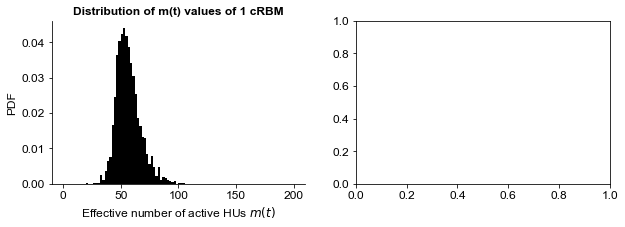

In [13]:
## PR activity 
fig, ax = plt.subplots(1, 2, figsize=[10, 3])
save_fig = False

## Example fish: 
pr_hus = af.part_ratio_hu_activity(tmp_hu_act_depeaked, set_zero=False)
ax[0].hist(pr_hus * RBM.n_h, bins=np.linspace(0, 200, 101), density=True,
        fc='k'); # idth=0.005
ax[0].set_xlabel('Effective number of active HUs $m(t)$')
ax[0].set_ylabel('PDF')
ax[0].set_title('Distribution of m(t) values of 1 cRBM',
             fontdict={'weight': 'bold'})
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
print(np.median(pr_hus), np.median(pr_hus) * RBM.n_h)

## All fish:
n_rbms_pr = len(pr_dict)
median_pr_arr = np.zeros(n_rbms_pr)
i_rbm = 0
for name, pr_distr in pr_dict.items():
    median_pr_arr[i_rbm] = np.median(pr_distr)
    i_rbm += 1

# tmp_glassy = np.random.normal(size=hu_activity_effectively_demeaned.shape,
#                               loc=np.mean(hu_act_test_remap), scale=np.std(hu_act_test_remap))

tmp_glassy = np.zeros_like(hu_act_test_remap)
assert tmp_glassy.shape[0] == 200
for mu in range(tmp_glassy.shape[0]):  # create gaussian with mu, sigma per HU
    tmp_glassy[mu, :] = np.random.normal(size=tmp_hu_act_depeaked.shape[1],
                                         loc=np.mean(tmp_hu_act_depeaked[mu, :]), 
                                         scale=np.std(tmp_hu_act_depeaked[mu, :]))

    
glassy_bound = np.median([af.p_metric_per_hu(tmp_glassy[ii, :], a=2) for ii in range(tmp_glassy.shape[0])])
    
ferro_bound = 0.05
    
ax[1].axvspan(xmin=0, xmax=ferro_bound, facecolor='#D7A9E3', alpha=0.4)
ax[1].axvspan(xmin=ferro_bound, xmax=glassy_bound, facecolor='#8BBEE8', alpha=0.3)
ax[1].axvspan(xmin=glassy_bound, xmax=1, facecolor='#A8D5BA', alpha=0.3)
tmp = ax[1].hist(median_pr_arr, bins=np.linspace(0, 1, 21), color='k', 
           rwidth=0.8, density=False)
ax[1].set_xlabel('Median ' + r'$\frac{m(t)}{M}$')
ax[1].set_ylabel('Frequency')
ax[1].set_yticks([int(x) for x in range(0, 16, 5)])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Median ' + r'$\frac{\mathbf{m}}{\mathbf{M}}$' + f' values of {len(median_pr_arr)} cRBMs', fontdict={'weight': 'bold'})
ax[1].set_ylim([0, 20])
ax[1].text(s='ferromagnetic', x=0.007, y=10, rotation=90)
ax[1].text(s='compositional', x=0.1, y=10, rotation=60)
ax[1].text(s='spin-glass', x=0.55, y=10, rotation=0)


ax[0].text(s='A', x=-48, y=0.057, fontdict={'weight': 'bold'})
ax[0].text(s='B', x=223, y=0.057, fontdict={'weight': 'bold'})

# ax[1].set_xscale('log')
if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/sfig_compositional.pdf', bbox_inches='tight')

In [140]:
# n_cells_per_ds_dict, time_per_ds_dict, freq_per_ds_dict = af.n_cells_all_recordings()
# time_sec_per_ds_dict = {}
# for key in time_per_ds_dict.keys():
#     time_sec_per_ds_dict[key] = time_per_ds_dict[key] / freq_per_ds_dict[key]
n_cells_array = np.array(list(n_cells_per_ds_dict.values()))
n_times_array = np.array(list(time_sec_per_ds_dict.values()))
freq_array = np.array(list(freq_per_ds_dict.values()))

for name, array in zip(['cells', 'time points', 'frequency'], (n_cells_array, n_times_array, freq_array)):
    print(f'Mean # {name}: {np.mean(array)}')
    print(f'Std # {name}: {np.std(array)}')
    print(f'Max # {name}: {np.max(array)}')
    print(f'Min # {name}: {np.min(array)}')


Mean # cells: 40708.625
Std # cells: 13854.01338004172
Max # cells: 65517
Min # cells: 23446
Mean # time points: 1514.7813712060452
Std # time points: 238.13155966197021
Max # time points: 1804.4541910290718
Min # time points: 1106.2287876605988
Mean # frequency: 3.887739839818934
Std # frequency: 0.7557211823100969
Max # frequency: 4.999986514485491
Min # frequency: 3.3003290254073083


In [87]:
def potential_funct(RBM, mu=10, h=0):
    h_plus = np.max(h, 0)
    h_min = np.max(-1 * h, 0)
    term_1 = 0.5 * RBM.hlayer._gamma_plus[0, mu] * (h_plus ** 2)
    term_2 = 0.5 * RBM.hlayer._gamma_minus[0, mu] * (h_min ** 2)
    term_3 = RBM.hlayer._theta_plus[0, mu] * h_plus
    term_4 = RBM.hlayer._theta_minus[0, mu] * h_min
    return term_1 + term_2 + term_3 + term_4



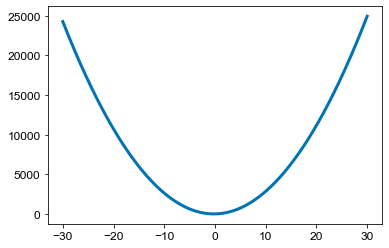

In [89]:
input_array = np.linspace(-30, 30, 1000)
mu = 55
potential = np.zeros_like(input_array)
for i_x, x in enumerate(input_array):
    potential[i_x] = potential_funct(RBM=RBM, mu=mu, h=x)
plt.plot(input_array, potential)

# Dynamics plot


In [14]:
## Load HU colours
colour_dict_path = '/home/thijs/repos/zf-rbm/figures/figure_intro/colours_2021-01-22.pkl'

with open(colour_dict_path, 'rb') as f:
    colour_hu_dict = pickle.load(f)
mu_colour_dict = {int(k[-3:]): v[1] for k, v in colour_hu_dict.items()}
mu_colour_dict[38] = '#14dc1b'
mu_colour_dict[87] = '#7a2840'
mu_colour_dict[191] = '#a28883'
mu_colour_dict[124] = '#fad798'

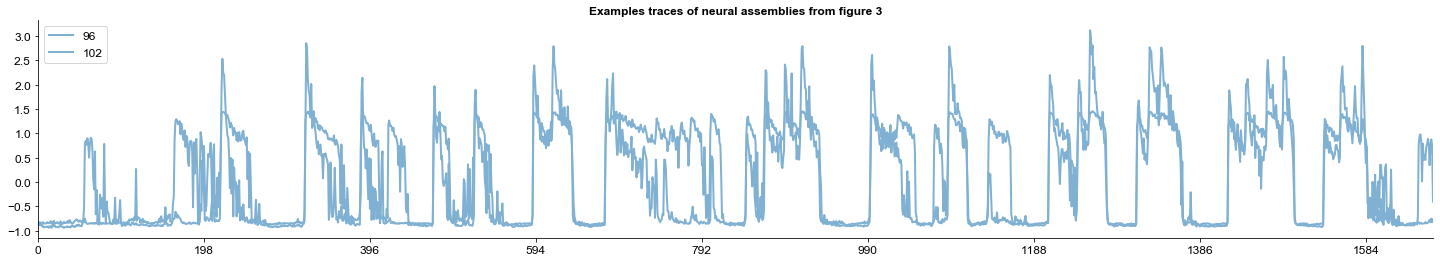

In [20]:
plt.rcParams['figure.figsize'] = (25, 4)
ax_examples = {0: plt.subplot(111)}

## Example traces:

# mu_plot_list = [45, 47, 53, 83]
# mu_plot_list = [53, 47, 59]
mu_plot_list = [96, 102]

i_plot = 0
for ii_plot, mu in enumerate(mu_plot_list):
#     ax_examples[i_plot] = fig.add_subplot(gs[2][i_plot])
#     for mu in mu_list:
    ax_examples[i_plot].plot(hu_activity_effectively_demeaned[mu, :], linewidth=2,
                             c= mu_colour_dict[mu], alpha=1, label=mu)
    ax_examples[i_plot].spines['top'].set_visible(False)
    ax_examples[i_plot].spines['right'].set_visible(False)
    ax_examples[i_plot].set_xticks([x * int(60 * freq) for x in range(9)])
    ax_examples[i_plot].margins(x=0)
#     ax_examples[i_plot].set_ylim([-1.2, 3.9])
#     ax_examples[i_plot].text(s=f'HU {mu}', x=1700, y=0.8, #  (3{fig_3_label_dict[mu]})
#                              fontdict={'color': mu_colour_dict[mu], 'weight': 'bold'})
#     ax_examples[i_plot].text(s=f'HU {mu_list[1]} (3{fig_3_label_dict[mu_list[1]]})', x=1700, y=-1.2, 
#                              fontdict={'color': mu_colour_dict[mu_list[1]], 'weight': 'bold'})
#     if i_plot == 5:
#     ax_examples[i_plot].set_xticklabels((np.round(ax_raster.get_xticks() / freq)).astype('int'),
#                               rotation=0)
#     else:
#         ax_examples[i_plot].set_xticklabels([])
ax_examples[0].set_title('Examples traces of neural assemblies from figure 3', fontdict={'weight': 'bold'})
# ax_examples[3].set_ylabel('              HU activity (a.u.)')
# ax_examples[5].set_xlabel('Time (s)'); #ax_raster.set_ylabel('Hidden Unit (HU) ID')
ax_examples[0].legend(loc='upper left')

## Notes clustsers:
* 0 - 12: OT right
* 13 - 17: OT right (some different peaks)
* 18 - 21: Di/Teg/OT right (sparse)
* 22 - 24: OT right (sparse)
* 25 - 35 OT right (different activity, long bursts). but also TSC/Teg at the end
* 36 - 57: Ventral Th / OT left/right. nMLF
* 58 - 77: OT left
* 78 - 86: Di (long bursts)
* 87 - 90: Ant Di
* 91 - 108: left oscillator Rh (spiking and then bursts)
* 109 - 124: symm Rh (spiking
* 125 - 135: Rh mostly (spars)
* 136 - 148: symm Rh, either together or split
* 149 - 160: sort of symm still 
* 161 - 174: rigth oscillator
* 175 - 199: miscellaneous: Forebrain (177 178)

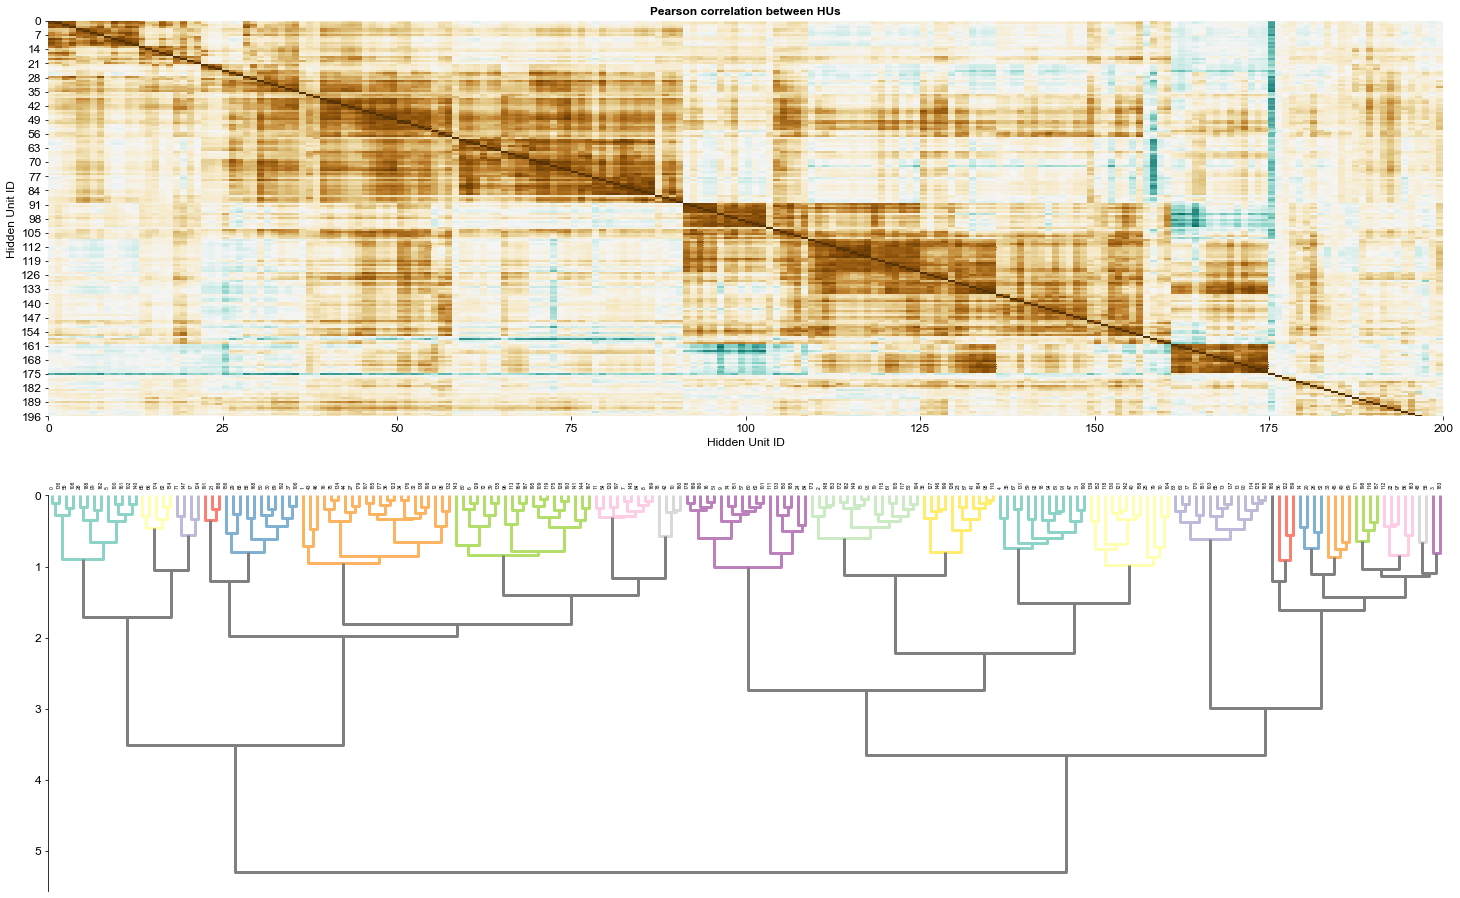

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(25, 16))


ax_dend = ax[1]
ax_corr = ax[0]

# corr_mat_hus = np.corrcoef(hu_activity_effectively_demeaned)
corr_mat_hus = 1 - scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(hu_activity_effectively_demeaned, metric='correlation')) # also pear coff, but this is the one used for clustering. (but again, exactly the same)



cmap_dendo = plt.cm.Set3(np.linspace(0, 1, 12))  # define colours as n_colors x 4 (RGBA) matrix

## set colours of clusters, 
cluster_color_dict = {**{x: matplotlib.colors.rgb2hex(cmap_dendo[0, :3]) for x in range(22)},
                      **{x: matplotlib.colors.rgb2hex(cmap_dendo[9, :3]) for x in range(22, 58)},
                      **{x: matplotlib.colors.rgb2hex(cmap_dendo[2, :3]) for x in range(58, 78)},
                      **{x: matplotlib.colors.rgb2hex(cmap_dendo[3, :3]) for x in range(78, 91)},
                      **{x: matplotlib.colors.rgb2hex(cmap_dendo[4, :3]) for x in range(91, 109)},
                      **{x: matplotlib.colors.rgb2hex(cmap_dendo[5, :3]) for x in range(109, 161)},
                      **{x: matplotlib.colors.rgb2hex(cmap_dendo[6, :3]) for x in range(161, 175)},
                      **{x: matplotlib.colors.rgb2hex(cmap_dendo[7, :3]) for x in range(175, 200)}}

cluster_name_color_dict = {'OT-R': matplotlib.colors.rgb2hex(cmap_dendo[0, :3]),
                           'Midbrain': matplotlib.colors.rgb2hex(cmap_dendo[9, :3]),
                           'OT-L': matplotlib.colors.rgb2hex(cmap_dendo[2, :3]),
                           'Di': matplotlib.colors.rgb2hex(cmap_dendo[3, :3]),
                           'ARTR-L': matplotlib.colors.rgb2hex(cmap_dendo[4, :3]),
                           'Hindbrain': matplotlib.colors.rgb2hex(cmap_dendo[5, :3]),
                           'ARTR-R': matplotlib.colors.rgb2hex(cmap_dendo[6, :3]),
                           'Misc.': matplotlib.colors.rgb2hex(cmap_dendo[7, :3])}


dict_leaf_colors = {mu: cluster_color_dict[ii] for ii, mu in enumerate(ol)}  # colours leaves according to sorting
dflt_col = '#808080'    
## colours combining links (https://stackoverflow.com/questions/38153829/custom-cluster-colors-of-scipy-dendrogram-in-python-link-color-func)
for i_link, two_points in enumerate(link_mat[:, :2].astype(int)):
    c1, c2 = dict_leaf_colors[two_points[0]], dict_leaf_colors[two_points[1]]
    if c1 == c2:  # if same colour, then also the link
        dict_leaf_colors[i_link + 1 + len(link_mat)] = c1 
    else:  # if different colour, then make grey
        dict_leaf_colors[i_link + 1 + len(link_mat)] = dflt_col

## plot dendogram using defined colours from above
# scipy.cluster.hierarchy.dendrogram(link_mat, color_threshold=None, ax=ax_dend, orientation='bottom',
#                                    link_color_func=lambda x: dict_leaf_colors[x]);

# Alternatively, default colouring 
scipy.cluster.hierarchy.set_link_color_palette([matplotlib.colors.rgb2hex(rgb[:3]) for rgb in cmap_dendo])
scipy.cluster.hierarchy.dendrogram(link_mat, color_threshold=1, ax=ax_dend, orientation='bottom',
                                   above_threshold_color='grey')

sns.heatmap(corr_mat_hus, cbar=False, ax=ax_corr, 
            vmin=-1, vmax=1,cmap='BrBG_r', 
#             cmap=sns.cubehelix_palette(start=.5, rot=-1, dark=0.25, light=1, 
#                                     reverse=True, as_cmap=True, n_colors=10),
            linewidths=0, rasterized=True)
for frameline in ['top', 'right', 'bottom']:
    ax_dend.spines[frameline].set_visible(False)

ax_corr.set_title('Pearson correlation between HUs', fontdict={'weight': 'bold'})
ax_corr.set_xlabel('Hidden Unit ID'); ax_corr.set_ylabel('Hidden Unit ID');
ax_corr.set_xticks([x * 25 for x in range(9)])
ax_corr.set_xticklabels([str(x * 25) for x in range(9)], rotation=0);

# plt.savefig('/home/thijs/repos/zf-rbm/figures/dynamics_clustering_help_fig.pdf')

cut off decreased to max degree 13


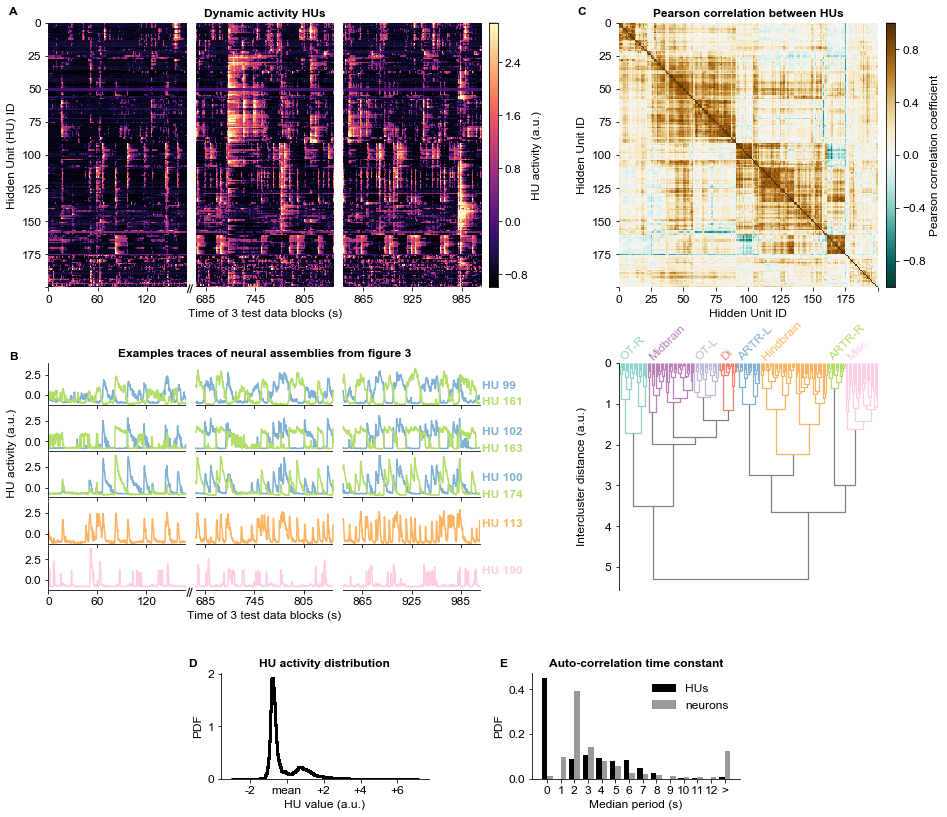

In [29]:

plt.rcParams['figure.figsize'] = (12, 10.5)
save_fig = False

fig = plt.figure(constrained_layout=False)
gs = {}
gs[0] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.65, top=1, left=0, right=0.52)  # raster
gs[1] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.65, top=1, left=0.66, right=0.96)  # pearson mat
gs[5] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.65, top=1, left=0.97, right=0.98)  # color bar
gs[2] = fig.add_gridspec(ncols=1, nrows=5, bottom=0.25, top=0.55, left=0, right=0.50, hspace=0.1)  # examples 
gs[4] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.25, top=0.55, left=0.66, right=0.96, hspace=0.1)  # dendo

gs[3] = fig.add_gridspec(ncols=2, nrows=1, bottom=0, top=0.14, left=0.2, right=0.8, wspace=0.5)  # hists

## Dynamic activity raster plot
ax_raster = fig.add_subplot(gs[0][0])
assert len(test_inds) == hu_activity_effectively_demeaned.shape[1]
assert test_segs == '267'  # discontinuity between 2 and 6
n_extra_tp = 40  # shift becaues of discontinuity in test dat (segs 267)
plot_hu_act_mat = np.zeros((hu_activity_effectively_demeaned.shape[0], hu_activity_effectively_demeaned.shape[1] + 2 * n_extra_tp))
split_tp = int(np.where(np.diff(test_inds) > 1)[0]) + 1
plot_hu_act_mat[:, :split_tp] = hu_activity_effectively_demeaned[:, :split_tp]
plot_hu_act_mat[:, split_tp:(split_tp + n_extra_tp)] = np.nan
plot_hu_act_mat[:, (split_tp + n_extra_tp):(2 * split_tp + n_extra_tp)] = hu_activity_effectively_demeaned[:, split_tp:(2 * split_tp)]
plot_hu_act_mat[:, (2 * split_tp + n_extra_tp):(2 * split_tp + 2 * n_extra_tp)] = np.nan
plot_hu_act_mat[:, (2 * split_tp + 2 * n_extra_tp):] = hu_activity_effectively_demeaned[:, (2 * split_tp):]
sns.heatmap(plot_hu_act_mat, vmin=-1, vmax=3, 
            cbar=False, cmap='magma', ax=ax_raster,
            linewidths=0, rasterized=True)
ax_raster.set_yticks(np.arange(9) * 25)
ax_raster.set_yticklabels([str(x * 25) for x in range(8)] + [''])
xticks_activity = np.array([x * int(60 * freq) for x in range(9)])
# xticklabels_activity = (np.round(xticks_activity / freq)).astype('int') # starting at 0
freq = 1 / np.mean(np.diff(rec.time))
xticklabels_activity = np.round(test_inds[xticks_activity] / freq).astype('int')  # real time 
xticks_activity = [x + n_extra_tp if x > split_tp else x for x in xticks_activity]  # shift after discontinuity
xticks_activity = [x + n_extra_tp if x > (2 * split_tp) else x for x in xticks_activity]  # shift after 2nd discontinuity
xticklabels_activity = xticklabels_activity - xticklabels_activity[0]  # subtract first one to start at 0

ax_raster.set_xticks(xticks_activity)
ax_raster.set_xticklabels(xticklabels_activity, rotation=0)
ax_raster.set_xlabel('Time of 3 test data blocks (s)'); ax_raster.set_ylabel('Hidden Unit (HU) ID')
divider = make_axes_locatable(ax_raster)
cax_rast = divider.append_axes('right', size='2%', pad=0.1)
rast_cb = mpl_colorbar(ax_raster.get_children()[0], cax=cax_rast)
rast_cb.solids.set_rasterized(True)
cax_rast.yaxis.set_ticks_position('right')
cax_rast.set_ylabel(r'HU activity (a.u.)')
ax_raster.set_title('Dynamic activity HUs', fontdict={'weight': 'bold'})

## Pearson correlation plot
ax_corr = fig.add_subplot(gs[1][0])
# corr_mat_hus = np.corrcoef(hu_activity_effectively_demeaned)
corr_mat_hus = 1 - scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(hu_activity_effectively_demeaned, metric='correlation'))
sns.heatmap(corr_mat_hus, cbar=False, ax=ax_corr, 
            vmin=-1, vmax=1,cmap='BrBG_r', 
#             cmap=sns.cubehelix_palette(start=.5, rot=-1, dark=0.25, light=1, 
#                                     reverse=True, as_cmap=True, n_colors=10),
            linewidths=0, rasterized=True)
ax_corr.set_title('Pearson correlation between HUs', fontdict={'weight': 'bold'})
ax_corr.set_xlabel('Hidden Unit ID');
ax_corr.set_xticks([x * 25 for x in range(9)])
ax_corr.set_xticklabels([str(x * 25) for x in range(8)] + [''], rotation=0)
ax_corr.set_yticks([x * 25 for x in range(9)])
ax_corr.set_yticklabels([str(x * 25) for x in range(8)] + ['']) 
ax_corr.set_ylabel('Hidden Unit ID');
# ax_corr.yaxis.set_label_position('left')

# divider = make_axes_locatable(ax_corr)
# cax_corr = divider.append_axes('right', size='3%', pad=0.1)
cax_corr = fig.add_subplot(gs[5][0])
corr_cb = mpl_colorbar(ax_corr.get_children()[0], cax=cax_corr)
corr_cb.solids.set_rasterized(True)
cax_corr.yaxis.set_ticks_position('right')
cax_corr.set_ylabel(r'Pearson correlation coefficient')

ax_dendo = fig.add_subplot(gs[4][0])
with plt.rc_context({'lines.linewidth': 1.25}):
    scipy.cluster.hierarchy.dendrogram(link_mat, color_threshold=None, ax=ax_dendo, orientation='bottom',
                                       link_color_func=lambda x: dict_leaf_colors[x],
                                       no_labels=True);
#     scipy.cluster.hierarchy.dendrogram(link_mat, color_threshold=1, ax=ax_dendo, orientation='bottom',
#                                        above_threshold_color='grey', no_labels=True)
for frameline in ['top', 'right', 'bottom']:
    ax_dendo.spines[frameline].set_visible(False)
ax_dendo.set_ylabel('Intercluster distance (a.u.)')

## Example traces:
mu_plot_dict = {0: [99, 161], 
                1: [102, 163], 2: [100, 174],
                3: [113], 4: [190]}
mu_colour_dict = cluster_color_dict
# fig_3_label_dict = {78: 'E', 45: 'H', 158: 'F', 157: 'I', 59: 'G', 128: 'J'}
ax_examples = {}
for i_plot, mu_list in mu_plot_dict.items():
    ax_examples[i_plot] = fig.add_subplot(gs[2][i_plot])
    for i_mu, mu in enumerate(mu_list):
        ax_examples[i_plot].plot(plot_hu_act_mat[mu, :], linewidth=1.5,
                                 c= mu_colour_dict[mu], alpha=1)
        ax_examples[i_plot].text(s=f'HU {mu}', x=1750, y=0.8 - 2 * i_mu, #  (3{fig_3_label_dict[mu]})
                 fontdict={'color': mu_colour_dict[mu], 'weight': 'bold'})
                
#     ax_examples[i_plot].text(s=f'HU {mu_list[1]} (3{fig_3_label_dict[mu_list[1]]})', x=1700, y=-1.2, 
#                              fontdict={'color': mu_colour_dict[mu_list[1]], 'weight': 'bold'})
    ax_examples[i_plot].spines['top'].set_visible(False)
    ax_examples[i_plot].spines['right'].set_visible(False)
    ax_examples[i_plot].set_xticks(xticks_activity)
    ax_examples[i_plot].margins(x=0)
    ax_examples[i_plot].set_ylim([-1.2, 3.9])

    ## Add white panels over discont. to hide x axis
    for x_add in [0, split_tp + n_extra_tp]:
        ax_examples[i_plot].axvspan(xmin=split_tp + x_add, xmax=split_tp + n_extra_tp + x_add, 
                                    ymin=-0.05, ymax=0.05, clip_on=False,
                                    facecolor='white', zorder=10)
    
    if i_plot == 4:
        ax_examples[i_plot].set_xticklabels(xticklabels_activity, rotation=0)
    else:
        ax_examples[i_plot].set_xticklabels([])
ax_examples[0].set_title('Examples traces of neural assemblies from figure 3', fontdict={'weight': 'bold'})
ax_examples[2].set_ylabel('              HU activity (a.u.)')
ax_examples[4].set_xlabel('Time of 3 test data blocks (s)'); 

## add break lines for time discont. 
for x_add in [10, 20]: 
    ax_examples[4].add_line(matplotlib.lines.Line2D(np.array([split_tp - 5 + x_add, split_tp + 5 + x_add]), np.array([-2, -1]), 
                                                 lw=1, color='k', alpha=1, clip_on=False, zorder=15))
    ax_raster.add_line(matplotlib.lines.Line2D(np.array([split_tp - 5 + x_add, split_tp + 5 + x_add]), np.array([204, 198]), 
                                                 lw=1, color='k', alpha=1, clip_on=False))
    
## Distirbution of HU activity
ax_hist_act = fig.add_subplot(gs[3][0])
ax_hist_act.hist(hu_activity_effectively_demeaned.flatten(), bins=200, histtype='step', 
                 linewidth=3, color='k', density=True);
ax_hist_act.set_xlabel('HU value (a.u.)'); ax_hist_act.set_ylabel('PDF');
ax_hist_act.set_title('HU activity distribution', weight='bold')
ax_hist_act.set_xticks([-2, 0 , 2, 4, 6])
ax_hist_act.set_xticklabels(['-2', 'mean', '+2', '+4', '+6'])
ax_hist_act.spines['right'].set_visible(False)
ax_hist_act.spines['top'].set_visible(False)

ax_hist_inter_mainstate = fig.add_subplot(gs[3][1])
pf.plot_degree_distr(degree_dict_sh={'ea': median_vu_period[:, 2].round().astype('int')},
                     degree_dict={'ea': median_period_duration.round().astype('int')},
                     ax=ax_hist_inter_mainstate, plot_shuffled=True,
                     cutoff=15, normalise=True, dr='ea', colour='k',
                     label='HUs', label_sh='neurons', v_spacing_greater=True)
# Note; in V1 of manuscript (Feb 2021) this was used for VU: np.sum(median_vu_period[:, :2], 1) instead of median_vu_period[:, 2]

ax_hist_inter_mainstate.set_xlabel('Median period (s)')
ax_hist_inter_mainstate.set_ylabel('PDF')
ax_hist_inter_mainstate.set_title('Auto-correlation time constant', weight='bold')
ax_hist_inter_mainstate.spines['right'].set_visible(False)
ax_hist_inter_mainstate.spines['top'].set_visible(False)
ax_hist_inter_mainstate.legend(loc='upper right', frameon=False)

ax_raster.annotate(s='A', xycoords='axes fraction', xy=(-0.09, 1.03), 
                  fontweight='bold')
ax_corr.annotate(s='C', xycoords='axes fraction', xy=(-0.16, 1.03), 
                  fontweight='bold')
ax_hist_act.annotate(s='D', xycoords='axes fraction', xy=(-0.16, 1.06), 
                  fontweight='bold')
ax_examples[0].annotate(s='B', xycoords='axes fraction', xy=(-0.09, 1.07), 
                  fontweight='bold')
ax_hist_inter_mainstate.annotate(s='E', xycoords='axes fraction', xy=(-0.16, 1.06), 
                  fontweight='bold')

for i_cl in range(len(cluster_name_color_dict)):
    cl_name = list(cluster_name_color_dict.keys())[i_cl]
    cl_color = cluster_name_color_dict[cl_name]
    cl_av_id = np.median(np.where(np.array(list(cluster_color_dict.values())) == cl_color)[0])
    cl_min_id = np.min(np.where(np.array(list(cluster_color_dict.values())) == cl_color)[0])
    ax_corr.text(s=cl_name, x=cl_min_id, y=255, 
                fontdict={'ha': 'left', 'rotation': 45, 'color': cl_color})

fig.align_ylabels(axs=[ax_corr, ax_dendo])
fig.align_ylabels(axs=[ax_raster, ax_examples[0], ax_examples[1], ax_examples[2]])
fig.align_xlabels(axs=[ax_examples[2], ax_hist_inter_mainstate])
fig.align_xlabels(axs=[ax_raster, ax_corr])

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_dynamics.pdf', 
                bbox_inches='tight', dpi=150)

In [141]:
555 / freq * 3

504.49515402317047

cut off decreased to max degree 13


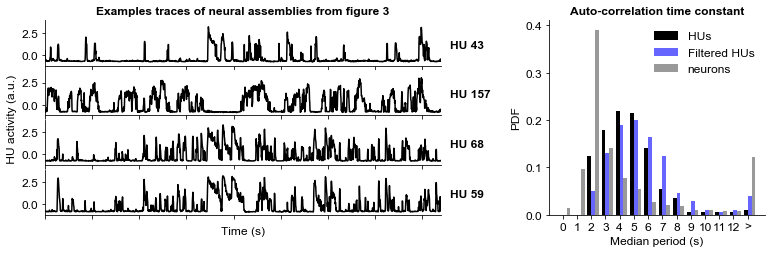

In [20]:
save_fig = False


fig = plt.figure(constrained_layout=False, figsize=[10, 3])
gs = {}
gs[0] = fig.add_gridspec(ncols=1, nrows=4, bottom=0.05, top=0.95, left=0, right=0.55, hspace=0.1)  # old format: top=0.28; bottom=0.45
gs[1] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.05, top=0.95, left=0.7, right=1)

78
## Example traces:
# mu_plot_dict = {0: (78, 45), 1: (35, 67), 2: (59, 128)}
# mu_plot_list = [78, 45, 43, 68, 87, 157]
mu_plot_list = [43, 157, 68, 59]
# mu_colour_dict = {k: color_cycle[k % 10] for k in range(200)}
# fig_3_label_dict = {78: 'E', 45: 'H', 158: 'F', 157: 'I', 59: 'G', 128: 'J'}
ax_examples = {}
for i_plot, mu in enumerate(mu_plot_list):
    ax_examples[i_plot] = fig.add_subplot(gs[0][i_plot])
#     for mu in mu_list:
    ax_examples[i_plot].plot(hu_activity_effectively_demeaned[mu, :], linewidth=1.5,
                             c='k', alpha=1)
    ax_examples[i_plot].spines['top'].set_visible(False)
    ax_examples[i_plot].spines['right'].set_visible(False)
    ax_examples[i_plot].set_xticks([x * int(60 * freq) for x in range(9)])
    ax_examples[i_plot].margins(x=0)
    ax_examples[i_plot].set_ylim([-1.2, 3.9])
    ax_examples[i_plot].text(s=f'HU {mu}', x=1700, y=0.8, #  (3{fig_3_label_dict[mu]})
                             fontdict={'color': 'k', 'weight': 'bold'})
#     ax_examples[i_plot].text(s=f'HU {mu_list[1]} (3{fig_3_label_dict[mu_list[1]]})', x=1700, y=-1.2, 
#                              fontdict={'color': mu_colour_dict[mu_list[1]], 'weight': 'bold'})
    if i_plot == 5:
        ax_examples[i_plot].set_xticklabels((np.round(ax_raster.get_xticks() / freq)).astype('int'),
                                  rotation=0)
    else:
        ax_examples[i_plot].set_xticklabels([])
ax_examples[0].set_title('Examples traces of neural assemblies from figure 3', fontdict={'weight': 'bold'})
ax_examples[2].set_ylabel('              HU activity (a.u.)')
ax_examples[3].set_xlabel('Time (s)'); #ax_raster.set_ylabel('Hidden Unit (HU) ID')



ax_distr = fig.add_subplot(gs[1][0])
pf.plot_three_degree_distr(degree_dict={'HUs': median_period_duration.round().astype('int'),
                                        'Filtered HUs': median_period_duration_filtered.round().astype('int'),
                                       'neurons': median_vu_period[:, 2].round().astype('int')},
                           cutoff=15, normalise=True, v_spacing_greater=True, ax=ax_distr,
                           colour_dict={'HUs': 'k', 'neurons': 'k', 'Filtered HUs': 'blue'},
                           alpha_dict={'HUs': 1, 'neurons': 0.4, 'Filtered HUs': 0.6})

ax_distr.set_xlabel('Median period (s)')
ax_distr.set_ylabel('PDF')
ax_distr.set_title('Auto-correlation time constant', weight='bold')
if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/sfig_filtered_hus_autocorrelation.pdf', bbox_inches='tight')

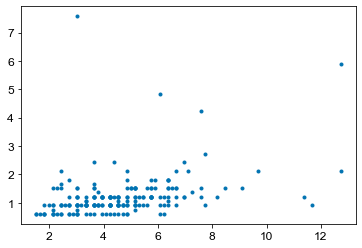

In [26]:
plt.plot(median_period_duration, median_burst_duration_filtered, '.')

cut off decreased to max degree 13


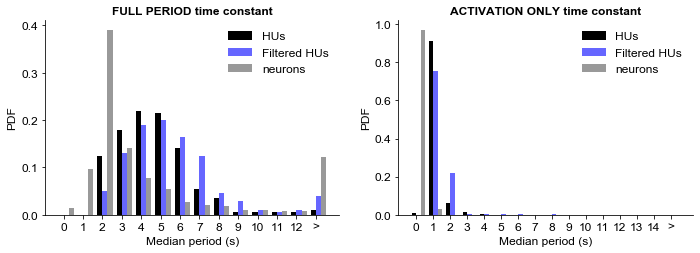

In [24]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=[10, 3])
gs = {}
gs[0] = fig.add_gridspec(ncols=2, nrows=1, bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.1)  # old format: top=0.28; bottom=0.45


ax_distr = fig.add_subplot(gs[0][0])
pf.plot_three_degree_distr(degree_dict={'HUs': median_period_duration.round().astype('int'),
                                        'Filtered HUs': median_period_duration_filtered.round().astype('int'),
                                       'neurons': median_vu_period[:, 2].round().astype('int')},
                           cutoff=15, normalise=True, v_spacing_greater=True, ax=ax_distr,
                           colour_dict={'HUs': 'k', 'neurons': 'k', 'Filtered HUs': 'blue'},
                           alpha_dict={'HUs': 1, 'neurons': 0.4, 'Filtered HUs': 0.6})

ax_distr.set_xlabel('Median period (s)')
ax_distr.set_ylabel('PDF')
ax_distr.set_title('FULL PERIOD time constant', weight='bold')


ax_distr2 = fig.add_subplot(gs[0][1])
pf.plot_three_degree_distr(degree_dict={'HUs': median_burst_duration.round().astype('int'),
                                        'Filtered HUs': median_burst_duration_filtered.round().astype('int'),
                                       'neurons': median_vu_period[:, 1].round().astype('int')},
                           cutoff=15, normalise=True, v_spacing_greater=True, ax=ax_distr2,
                           colour_dict={'HUs': 'k', 'neurons': 'k', 'Filtered HUs': 'blue'},
                           alpha_dict={'HUs': 1, 'neurons': 0.4, 'Filtered HUs': 0.6})

ax_distr2.set_xlabel('Median period (s)')
ax_distr2.set_ylabel('PDF')
ax_distr2.set_title('ACTIVATION ONLY time constant', weight='bold')

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/sfig_filtered_hus_autocorrelation.pdf', bbox_inches='tight')

cut off decreased to max degree 13


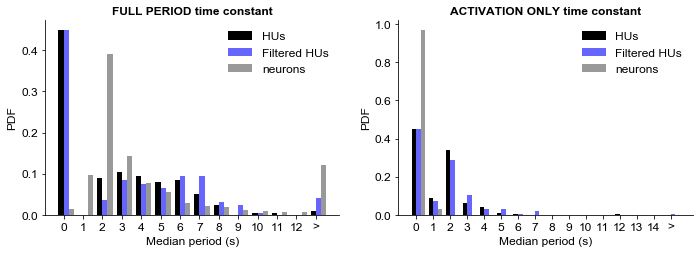

In [32]:
save_fig = False

fig = plt.figure(constrained_layout=False, figsize=[10, 3])
gs = {}
gs[0] = fig.add_gridspec(ncols=2, nrows=1, bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.1)  # old format: top=0.28; bottom=0.45


ax_distr = fig.add_subplot(gs[0][0])
pf.plot_three_degree_distr(degree_dict={'HUs': median_period_duration.round().astype('int'),
                                        'Filtered HUs': median_period_duration_filtered.round().astype('int'),
                                       'neurons': median_vu_period[:, 2].round().astype('int')},
                           cutoff=15, normalise=True, v_spacing_greater=True, ax=ax_distr,
                           colour_dict={'HUs': 'k', 'neurons': 'k', 'Filtered HUs': 'blue'},
                           alpha_dict={'HUs': 1, 'neurons': 0.4, 'Filtered HUs': 0.6})

ax_distr.set_xlabel('Median period (s)')
ax_distr.set_ylabel('PDF')
ax_distr.set_title('FULL PERIOD time constant', weight='bold')


ax_distr2 = fig.add_subplot(gs[0][1])
pf.plot_three_degree_distr(degree_dict={'HUs': median_burst_duration.round().astype('int'),
                                        'Filtered HUs': median_burst_duration_filtered.round().astype('int'),
                                       'neurons': median_vu_period[:, 1].round().astype('int')},
                           cutoff=15, normalise=True, v_spacing_greater=True, ax=ax_distr2,
                           colour_dict={'HUs': 'k', 'neurons': 'k', 'Filtered HUs': 'blue'},
                           alpha_dict={'HUs': 1, 'neurons': 0.4, 'Filtered HUs': 0.6})

ax_distr2.set_xlabel('Median period (s)')
ax_distr2.set_ylabel('PDF')
ax_distr2.set_title('ACTIVATION ONLY time constant', weight='bold')

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/sfig_filtered_hus_autocorrelation.pdf', bbox_inches='tight')

Text(0.5, 1, 'Dynamic activity HUs')

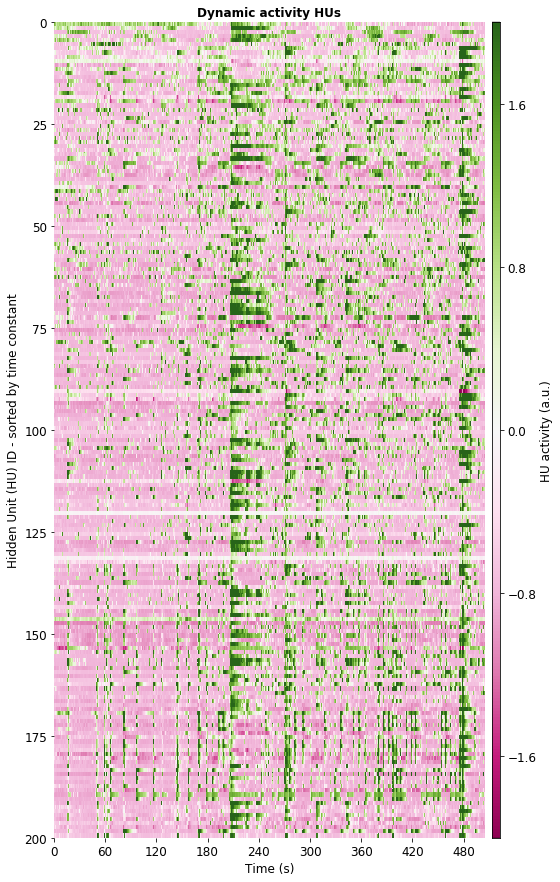

In [48]:
inds_time_constant = np.argsort(median_period_duration)  # time constant, in remap (ie sorted by ol) format

fig, ax_raster = plt.subplots(1, 1, figsize=[8, 15])
sns.heatmap(hu_activity_effectively_demeaned[inds_time_constant, :], 
#             vmin=-1, vmax=3, cmap='magma',
            vmin=-2, vmax=2, cmap='PiYG',
            cbar=False, ax=ax_raster)
ax_raster.set_yticks([x * 25 for x in range(9)])
ax_raster.set_yticklabels(ax_raster.get_yticks())
ax_raster.set_xticks([x * int(60 * freq) for x in range(9)])
ax_raster.set_xticklabels((np.round(ax_raster.get_xticks() / freq)).astype('int'),
                          rotation=0)
ax_raster.set_xlabel('Time (s)'); ax_raster.set_ylabel('Hidden Unit (HU) ID - sorted by time constant')
divider = make_axes_locatable(ax_raster)
cax_rast = divider.append_axes('right', size='2%', pad=0.1)
mpl_colorbar(ax_raster.get_children()[0], cax=cax_rast)
cax_rast.yaxis.set_ticks_position('right')
cax_rast.set_ylabel(r'HU activity (a.u.)')
ax_raster.set_title('Dynamic activity HUs', fontdict={'weight': 'bold'})


8.0


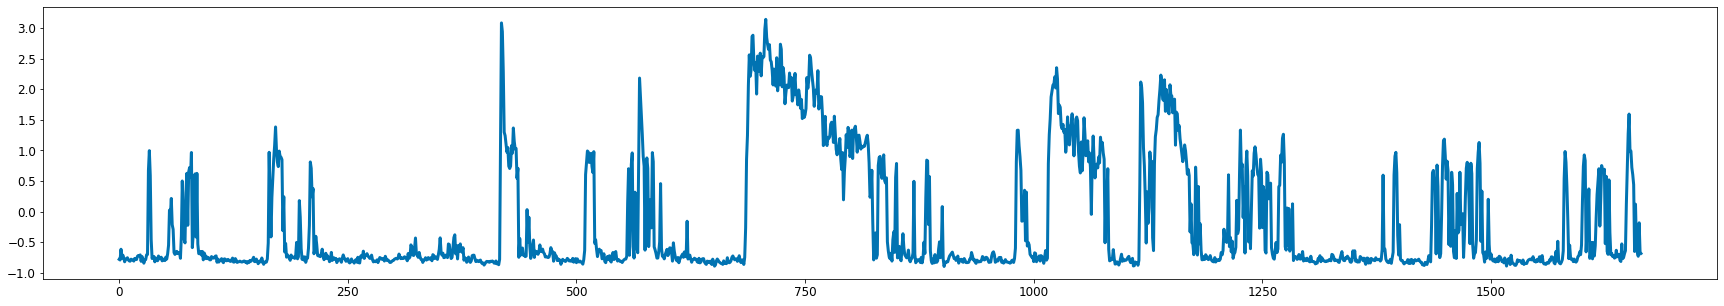

In [66]:

mu = 20
fig, ax = plt.subplots(1, 1, figsize=[30, 5])
ax.plot(hu_activity_effectively_demeaned[inds_time_constant[mu], :])
print(median_period_duration[inds_time_constant[mu]] * freq)

## Jerome's autocorrelation

In [358]:
mu = 0

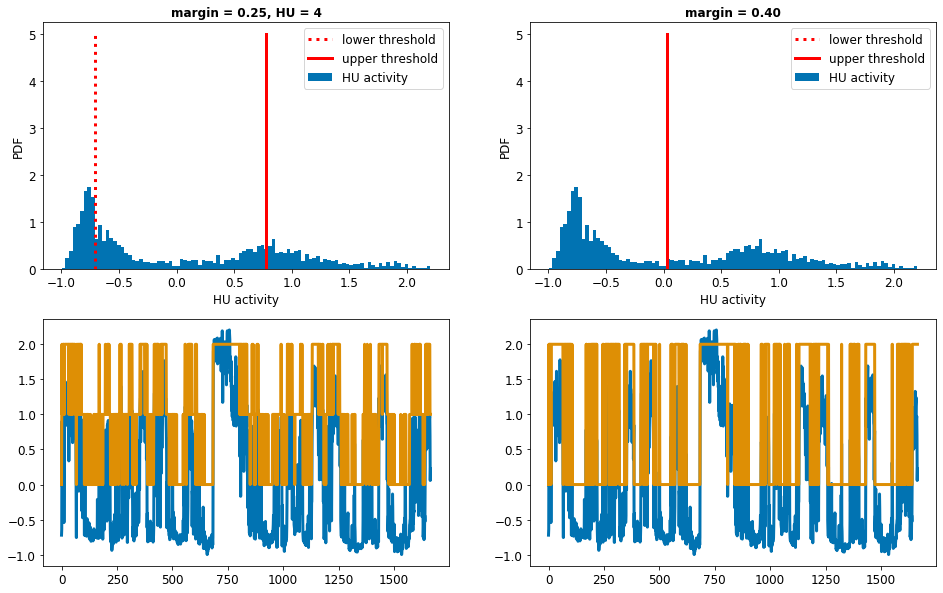

In [362]:
plt.rcParams['figure.figsize'] = (16, 10)
mu += 1
fig, axes = plt.subplots(2, 2)
tmp25 = af.discretize(hu_act_test_remap[mu, :], plot=True, margin=0, ax=axes[0, 0])
tmp40 = af.discretize(hu_act_test_remap[mu, :], plot=True, margin=0.5, ax=axes[0, 1])
axes[0, 0].set_title(f'margin = 0.25, HU = {mu}', fontdict={'weight': 'bold'})
axes[0, 1].set_title('margin = 0.40', fontdict={'weight': 'bold'})

axes[1, 0].plot(hu_act_test_remap[mu, :])
axes[1, 0].plot(tmp25)
axes[1, 1].plot(hu_act_test_remap[mu, :])
axes[1, 1].plot(tmp40);
# 0.25 bad for HUs: 3, 6, 11, 16, 18 (stopped after 20)
# 0.4 bit tight for HUs: 29, 56, 117

In [ ]:
# median_silence_duration, median_burst_duration, median_period_duration, count_bursts = af.compute_median_discretised_state_occupancy(activity_mat=hu_act_test_remap, frequency=freq, margin=0.25)


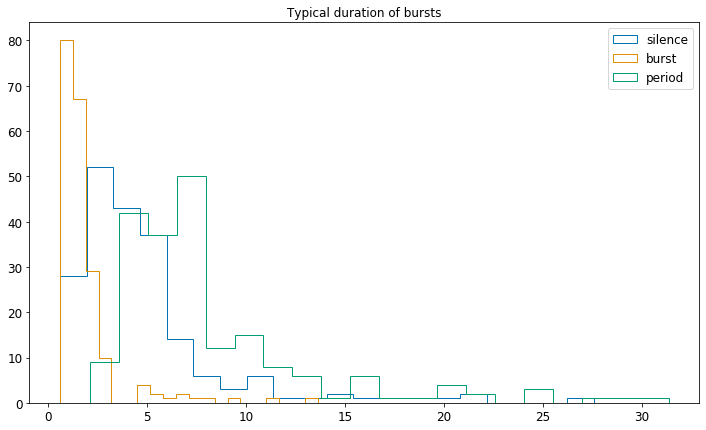

In [74]:
plt.hist(median_silence_duration / freq, bins=20, label='silence', histtype='step'); 
plt.hist(median_burst_duration  / freq, bins=20, label='burst', histtype='step');
plt.hist(median_period_duration  / freq, bins=20, histtype='step', label='period');
plt.title('Typical duration of bursts')
# plt.show()
plt.legend()

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


44, 0.589,0.138,0.273


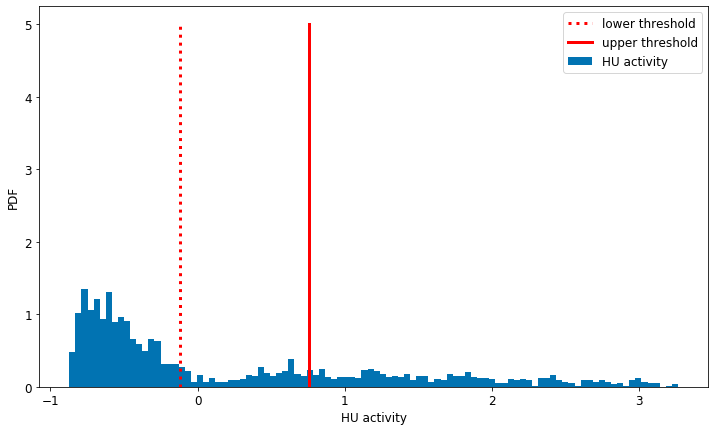

In [56]:
mu = np.argmax(median_burst_duration)

discrete_h = discretize(hu_act_test_remap[mu, :], margin=0.25,plot=True)
print('%s, %.3f,%.3f,%.3f'% (
    mu, 
    (discrete_h==0).mean(),
    (discrete_h==1).mean(),
    (discrete_h==2).mean()  )
     )

list_silence_durations,list_burst_durations = get_burst_and_silence_times(discrete_h)



# OLD stuff

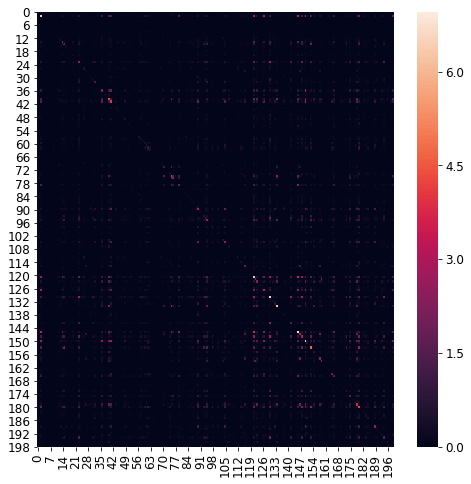

In [84]:
def adj_weights(weights):
    assert weights.shape[1] > weights.shape[0]
    tmp = np.abs(weights)
    mat = tmp.dot(tmp.T)
#     print(mat.shape)
    norm_els = np.diag(mat)
    norm_mat = norm_els[:, np.newaxis] + norm_els[np.newaxis, :]
    result = 2 * mat / norm_mat
#     np.fill_diagonal(result, 0.01)
    return result
    
def neurons_per_region_per_hu(RBM=RBM, rec=rec, mu=0, abs_th=0.05,
                              selection_neurons=selected_neurons['wb']):
    ## plot region occupancy
    hu_weights = RBM.weights[mu, :]
    vu_labels = rec.labels[selection_neurons, :]
    vu_selection = np.abs(hu_weights) >= abs_th  # VUs with weights absolute value geq threshold
    vu_selection_labels = vu_labels[vu_selection, :]  # their label
    n_vu_per_region_total = np.squeeze(np.array(vu_labels.sum(0)))  # total number of neurons per region
    n_vu_per_region = np.squeeze(np.array(vu_selection_labels.sum(0)))  # number of these neurons per region
    inds_nz = np.where(n_vu_per_region_total > 0)
    n_vu_per_region_normalised = n_vu_per_region
    n_vu_per_region_normalised[inds_nz] = n_vu_per_region[inds_nz] / n_vu_per_region_total[inds_nz]
    
    return n_vu_per_region, n_vu_per_region_normalised

region_occupancy_hus = np.zeros((RBM.weights.shape[0], rec.labels.shape[1]))
for mu in range(RBM.weights.shape[0]):
    _, region_occupancy_hus[mu, :] = neurons_per_region_per_hu(mu=mu)
adj_mat = np.dot(region_occupancy_hus, region_occupancy_hus.transpose())
# sns.heatmap(np.log(region_occupancy_hus + 1), cmap='Greys')

# adj_mat = adj_weights(RBM.weights[ol, :])

# plt.rcParams['figure.figsize'] = (8, 8)
sns.heatmap(adj_mat)
# plt.xlabel('# HU')
# plt.ylabel('# HU')
# plt.title('Log dot product between HUs');

In [80]:
adj_mat

array([[ 1.        ,  0.19453328, -0.04642224, ...,  0.38378943,
         0.02679237, -0.03724182],
       [ 0.19453328,  1.        , -0.06875138, ...,  0.15449964,
        -0.00776811, -0.01531467],
       [-0.04642224, -0.06875138,  1.        , ..., -0.06436475,
         0.00412454,  0.43714402],
       ...,
       [ 0.38378943,  0.15449964, -0.06436475, ...,  1.        ,
         0.04374877, -0.02130514],
       [ 0.02679237, -0.00776811,  0.00412454, ...,  0.04374877,
         1.        ,  0.11123294],
       [-0.03724182, -0.01531467,  0.43714402, ..., -0.02130514,
         0.11123294,  1.        ]])

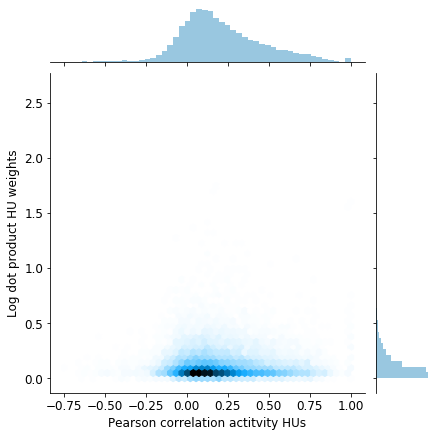

In [87]:

jp = sns.jointplot(corr_mat_hus.ravel(), np.sqrt(adj_mat.ravel()), kind='hex')
jp.set_axis_labels('Pearson correlation actitvity HUs', 
                   'Log dot product HU weights')

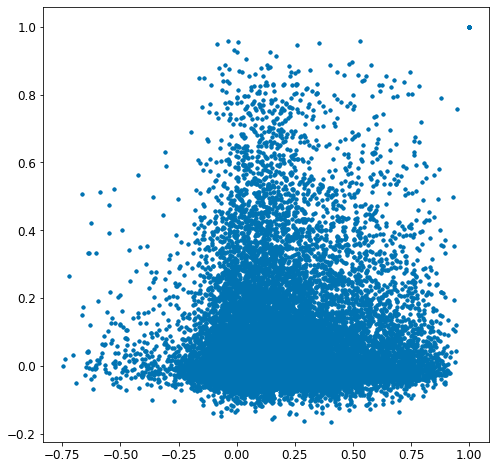

In [82]:
plt.plot(corr_mat_hus.ravel(), adj_mat.ravel(), '.')